In [ ]:
import zipfile
import pandas as pd
import os

# Assuming the zip file is located at this path
zip_file_path = '/content/diabetes+130-us+hospitals+for+years+1999-2008.zip'
extract_path = '/tmp'

# List the contents of the zip file to find the correct CSV file name
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    print("Files in the zip archive:")
    for file_info in zip_ref.infolist():
        print(file_info.filename)
    # Assuming the CSV file is the only file or easily identifiable,
    # replace 'dataset_diabetes.csv' with the actual file name found in the output
    # For this specific dataset, based on its source, the CSV file is likely named 'dataset_diabetes.csv'.
    # If the output above shows a different name, please update the csv_file_name variable.
    csv_file_name = 'diabetic_data.csv' # Update this if the printed list shows a different name

    # Extract the correct CSV file
    zip_ref.extract(csv_file_name, extract_path)

# Construct the full path to the extracted CSV file
csv_file_path = os.path.join(extract_path, csv_file_name)

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Display the first 5 rows
display(df.head())

# Print the concise summary
df.info()

# Display the number of rows and columns
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Files in the zip archive:
diabetic_data.csv
IDS_mapping.csv


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [ ]:
# Choose the best performing model (based on previous evaluation, let's assume XGBoost for now)
best_model = pipelines['XGBoost']

# Get the age groups from the original dataframe
age_groups = df['age'].unique()
age_groups.sort() # Optional: sort age groups for ordered evaluation

# Create a dictionary to store evaluation results for each age group
age_group_evaluation_results = {}

print("Evaluating model performance by age group...")

for age_group in age_groups:
    print(f"\nEvaluating for age group: {age_group}")

    # Filter the original DataFrame for the current age group
    df_age_group = df[df['age'] == age_group].copy()

    # Define features (X) and target (y) for the age group
    # Ensure consistent columns as the main training data
    X_age_group = df_age_group.drop(['readmitted', 'encounter_id', 'patient_nbr', 'diag_1', 'diag_2', 'diag_3', 'payer_code', 'medical_specialty'], axis=1)
    y_age_group = df_age_group['readmitted']

    # Check if there are enough samples in the age group for evaluation
    if len(y_age_group) == 0:
        print(f"  No data for age group {age_group}. Skipping evaluation.")
        continue

    # Make predictions for this age group using the already trained model
    # We use the already fitted pipeline to ensure consistency in preprocessing
    y_pred_age_group = best_model.predict(X_age_group)
    y_prob_age_group = best_model.predict_proba(X_age_group)[:, 1]


    # Calculate evaluation metrics for the age group
    cm_age_group = confusion_matrix(y_age_group, y_pred_age_group)
    recall_age_group = recall_score(y_age_group, y_pred_age_group)
    f1_age_group = f1_score(y_age_group, y_pred_age_group)
    roc_auc_age_group = roc_auc_score(y_age_group, y_prob_age_group)

    age_group_evaluation_results[age_group] = {
        'confusion_matrix': cm_age_group,
        'recall': recall_age_group,
        'f1': f1_age_group,
        'roc_auc': roc_auc_age_group
    }

    print(f"  Confusion Matrix:\n", cm_age_group)
    print(f"  Recall: {recall_age_group:.4f}")
    print(f"  F1 Score: {f1_age_group:.4f}")
    print(f"  ROC AUC: {roc_auc_age_group:.4f}")

# Display the evaluation results for each age group
print("\nModel Performance by Age Group:")
for age_group, metrics in age_group_evaluation_results.items():
    print(f"Age Group: {age_group}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1 Score: {metrics['f1']:.4f}")
    print(f"  ROC AUC: {metrics['roc_auc']:.4f}")

Evaluating model performance by age group...

Evaluating for age group: [0-10)
  Confusion Matrix:
 [[3]]
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: nan

Evaluating for age group: [10-20)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is pr

  Confusion Matrix:
 [[65  0]
 [ 1  0]]
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.8462

Evaluating for age group: [20-30)
  Confusion Matrix:
 [[396   3]
 [ 34  53]]
  Recall: 0.6092
  F1 Score: 0.7413
  ROC AUC: 0.9638

Evaluating for age group: [30-40)
  Confusion Matrix:
 [[812   4]
 [ 66  44]]
  Recall: 0.4000
  F1 Score: 0.5570
  ROC AUC: 0.9004

Evaluating for age group: [40-50)
  Confusion Matrix:
 [[2211   10]
 [ 187   78]]
  Recall: 0.2943
  F1 Score: 0.4419
  ROC AUC: 0.8823

Evaluating for age group: [50-60)
  Confusion Matrix:
 [[4049    9]
 [ 315   90]]
  Recall: 0.2222
  F1 Score: 0.3571
  ROC AUC: 0.8652

Evaluating for age group: [60-70)
  Confusion Matrix:
 [[5337   12]
 [ 508  103]]
  Recall: 0.1686
  F1 Score: 0.2837
  ROC AUC: 0.8658

Evaluating for age group: [70-80)
  Confusion Matrix:
 [[6028    7]
 [ 591  136]]
  Recall: 0.1871
  F1 Score: 0.3126
  ROC AUC: 0.8620

Evaluating for age group: [80-90)
  Confusion Matrix:
 [[4199    9]
 [ 466   88]]
  Recall:

## Model Interpretation



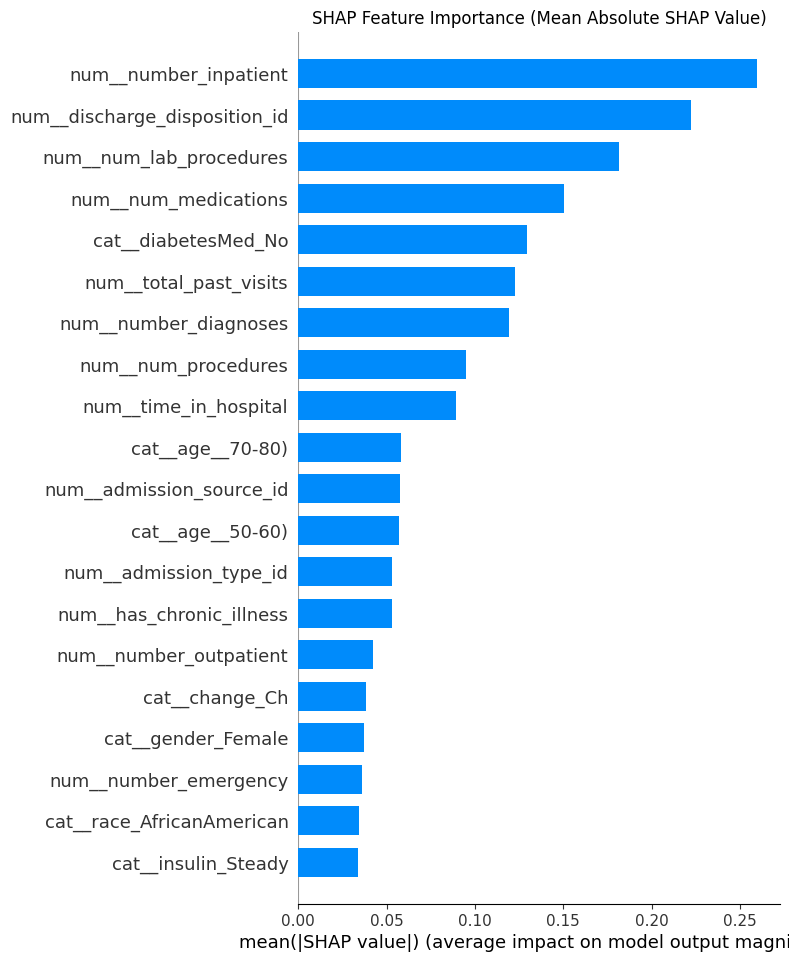

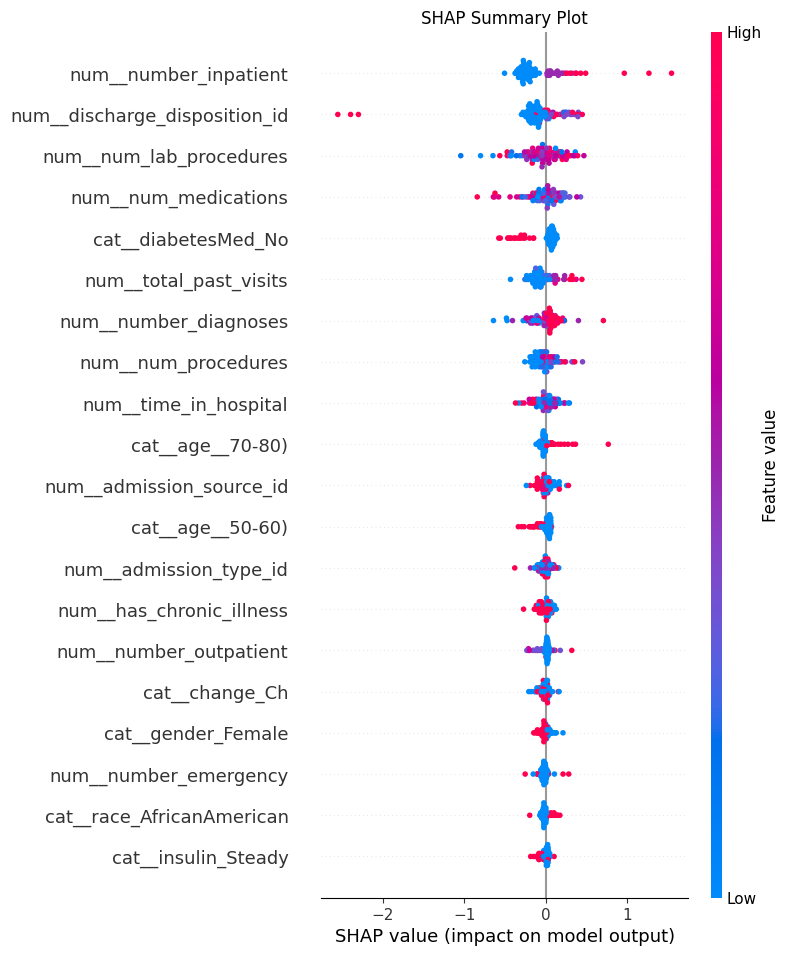

In [ ]:
# We will use SHAP for model interpretation.
# First, install the shap library if you haven't already.
!pip install shap

import shap

# Choose one of the trained models for interpretation (e.g., XGBoost as it performed best in CV)
# We need the trained pipeline object
model_to_interpret = pipelines['XGBoost']

# Since the pipeline includes a preprocessor, we need to apply the preprocessor to the training data
# to get the feature names after one-hot encoding
X_train_processed = model_to_interpret.named_steps['preprocessor'].transform(X_train)

# Get the feature names after preprocessing
# The preprocessor's get_feature_names_out() method is useful here
feature_names = model_to_interpret.named_steps['preprocessor'].get_feature_names_out()

# Clean up feature names to remove invalid characters for XGBoost/SHAP
cleaned_feature_names = [name.replace('<', '_lt_').replace('[', '_').replace(']', '_') for name in feature_names]


# SHAP requires a background dataset for explanation.
# Using a small sample of the training data is common practice for performance.
# For tree-based models like XGBoost, a smaller background dataset is sufficient.
explainer = shap.TreeExplainer(model_to_interpret.named_steps['classifier'])

# Calculate SHAP values for a sample of the test set
# Using a smaller sample makes the computation faster
X_test_sample = X_test.sample(n=100, random_state=42)
X_test_sample_processed = model_to_interpret.named_steps['preprocessor'].transform(X_test_sample)

# Convert the processed test sample back to a DataFrame with correct feature names
X_test_sample_processed_df = pd.DataFrame(X_test_sample_processed, columns=cleaned_feature_names)


shap_values = explainer.shap_values(X_test_sample_processed_df)

# Summarize the feature importances
shap.summary_plot(shap_values, X_test_sample_processed_df, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean Absolute SHAP Value)')
plt.show()

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test_sample_processed_df, show=False)
plt.title('SHAP Summary Plot')
plt.show()

## Model Evaluation


Evaluating models on the test set...
Evaluating Logistic Regression...
Logistic Regression Test Set Results:
  Confusion Matrix:
 [[4765   15]
 [ 555   16]]
  Recall: 0.0280
  F1 Score: 0.0532
  ROC AUC: 0.6507


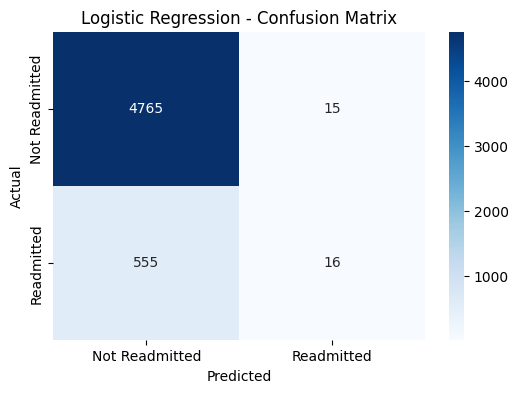

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


<Figure size 600x400 with 0 Axes>

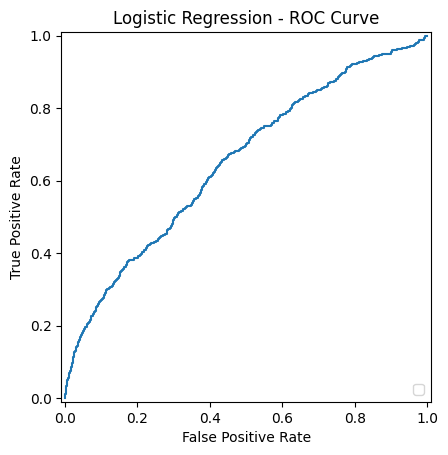

Evaluating Random Forest...
Random Forest Test Set Results:
  Confusion Matrix:
 [[4766   14]
 [ 557   14]]
  Recall: 0.0245
  F1 Score: 0.0467
  ROC AUC: 0.6437


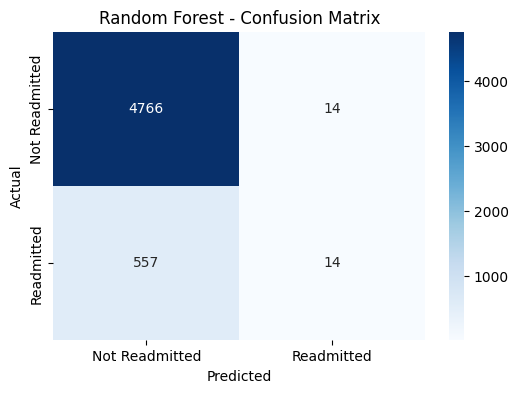

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


<Figure size 600x400 with 0 Axes>

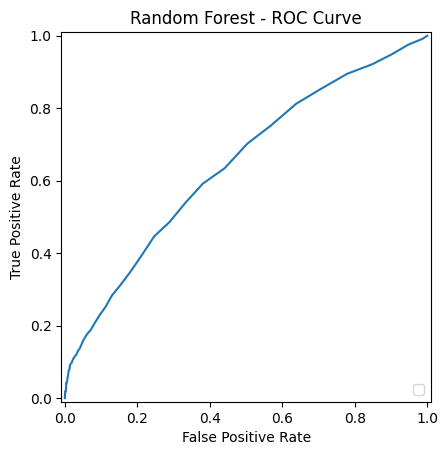

Evaluating XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:57:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Test Set Results:
  Confusion Matrix:
 [[4730   50]
 [ 538   33]]
  Recall: 0.0578
  F1 Score: 0.1009
  ROC AUC: 0.6485


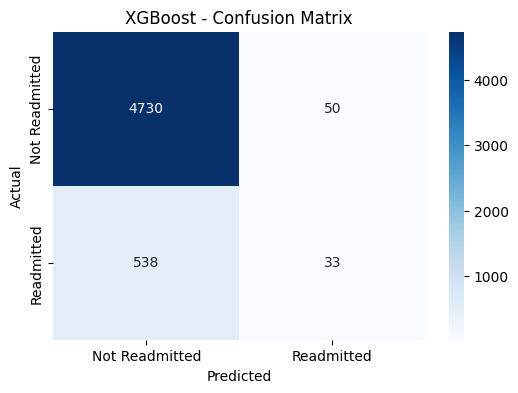

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


<Figure size 600x400 with 0 Axes>

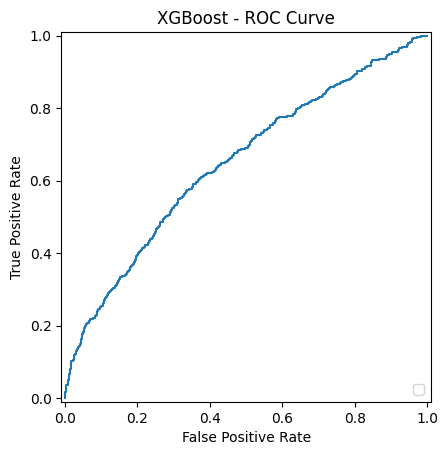


Test Set Evaluation Results:
Logistic Regression:
  Recall: 0.0280
  F1 Score: 0.0532
  ROC AUC: 0.6507
Random Forest:
  Recall: 0.0245
  F1 Score: 0.0467
  ROC AUC: 0.6437
XGBoost:
  Recall: 0.0578
  F1 Score: 0.1009
  ROC AUC: 0.6485


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluate models on the test set
evaluation_results = {}

print("Evaluating models on the test set...")

for name, pipeline in pipelines.items():
    print(f"Evaluating {name}...")
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probability of the positive class

    # Calculate evaluation metrics
    cm = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    evaluation_results[name] = {
        'confusion_matrix': cm,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

    print(f"{name} Test Set Results:")
    print("  Confusion Matrix:\n", cm)
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Readmitted', 'Readmitted'], yticklabels=['Not Readmitted', 'Readmitted'])
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC Curve
    plt.figure(figsize=(6, 4))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title(f'{name} - ROC Curve')
    plt.show()

# Display the test set evaluation results
print("\nTest Set Evaluation Results:")
for name, metrics in evaluation_results.items():
    print(f"{name}:")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1 Score: {metrics['f1']:.4f}")
    print(f"  ROC AUC: {metrics['roc_auc']:.4f}")

## Model Selection and Training


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import recall_score, f1_score, roc_auc_score, make_scorer

# Define the models
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Create a pipeline for each model
pipelines = {name: Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)]) for name, model in models.items()}

# Define scoring metrics
scoring = {
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Perform stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

print("Performing stratified cross-validation...")

for name, pipeline in pipelines.items():
    print(f"Training {name}...")
    cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    results[name] = {metric: cv_results[f'test_{metric}'].mean() for metric in scoring.keys()}
    print(f"{name} CV Results (Mean): {results[name]}")

# Display the average cross-validation scores
print("\nAverage Cross-Validation Scores:")
for name, metrics in results.items():
    print(f"{name}:")
    for metric, score in metrics.items():
        print(f"  {metric}: {score:.4f}")

Performing stratified cross-validation...
Training Logistic Regression...
Logistic Regression CV Results (Mean): {'recall': np.float64(0.021871327147812293), 'f1': np.float64(0.04157320224379726), 'roc_auc': np.float64(0.5093402837598102)}
Training Random Forest...
Random Forest CV Results (Mean): {'recall': np.float64(0.015307731264273362), 'f1': np.float64(0.029628449186187344), 'roc_auc': np.float64(0.5067384568587687)}
Training XGBoost...
XGBoost CV Results (Mean): {'recall': np.float64(0.04637038594211346), 'f1': np.float64(0.08227042283813482), 'roc_auc': np.float64(0.5183729576238902)}

Average Cross-Validation Scores:
Logistic Regression:
  recall: 0.0219
  f1: 0.0416
  roc_auc: 0.5093
Random Forest:
  recall: 0.0153
  f1: 0.0296
  roc_auc: 0.5067
XGBoost:
  recall: 0.0464
  f1: 0.0823
  roc_auc: 0.5184


## Data Preparation for Modeling


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define features (X) and target (y)
# Drop the original diagnosis columns as we created a chronic illness flag
# Drop 'encounter_id' and 'patient_nbr' as they are identifiers
X = df.drop(['readmitted', 'encounter_id', 'patient_nbr', 'diag_1', 'diag_2', 'diag_3', 'payer_code', 'medical_specialty'], axis=1)
y = df['readmitted']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Create a column transformer to apply one-hot encoding to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Split data into training and testing sets (using stratified split for the target variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of training data (X_train):", X_train.shape)
print("Shape of testing data (X_test):", X_test.shape)
print("Shape of training labels (y_train):", y_train.shape)
print("Shape of testing labels (y_test):", y_test.shape)

Shape of training data (X_train): (21404, 42)
Shape of testing data (X_test): (5351, 42)
Shape of training labels (y_train): (21404,)
Shape of testing labels (y_test): (5351,)


## Feature Engineering


In [ ]:
# Create Polypharmacy indicator (example: more than 5 medications)
df['polypharmacy'] = (df['num_medications'] > 5).astype(int)

# Create Chronic illness flags from diagnosis codes (simplified example)
# You would need a more comprehensive mapping for real-world scenarios
chronic_illness_codes = ['250', '401'] # Example codes for diabetes and hypertension
def check_chronic(row):
    for code in chronic_illness_codes:
        if (isinstance(row['diag_1'], str) and row['diag_1'].startswith(code)) or \
           (isinstance(row['diag_2'], str) and row['diag_2'].startswith(code)) or \
           (isinstance(row['diag_3'], str) and row['diag_3'].startswith(code)):
            return 1
    return 0

df['has_chronic_illness'] = df.apply(check_chronic, axis=1)


# Count of past procedures/admissions
# 'number_inpatient', 'number_emergency', and 'number_outpatient' already represent this
# We can create a total past visits feature
df['total_past_visits'] = df['number_inpatient'] + df['number_emergency'] + df['number_outpatient']


# Display the first few rows with new features
display(df[['num_medications', 'polypharmacy', 'diag_1', 'diag_2', 'diag_3', 'has_chronic_illness', 'number_inpatient', 'number_emergency', 'number_outpatient', 'total_past_visits', 'readmitted']].head())

,num_medications,polypharmacy,diag_1,diag_2,diag_3,has_chronic_illness,number_inpatient,number_emergency,number_outpatient,total_past_visits,readmitted
20446,15,1,821,276,285,0,0,0,0,0,0
20737,11,1,V56,403,599,0,0,0,0,0,0
20824,9,1,532,428,535,0,0,0,0,0,0
21083,18,1,682,427,276,0,0,0,0,0,0
23879,19,1,238,250.02,733,1,0,0,0,0,0


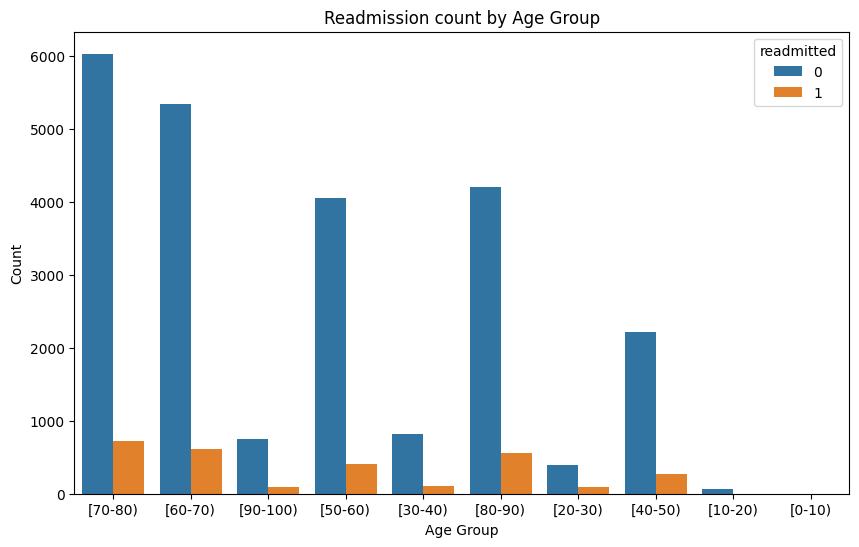

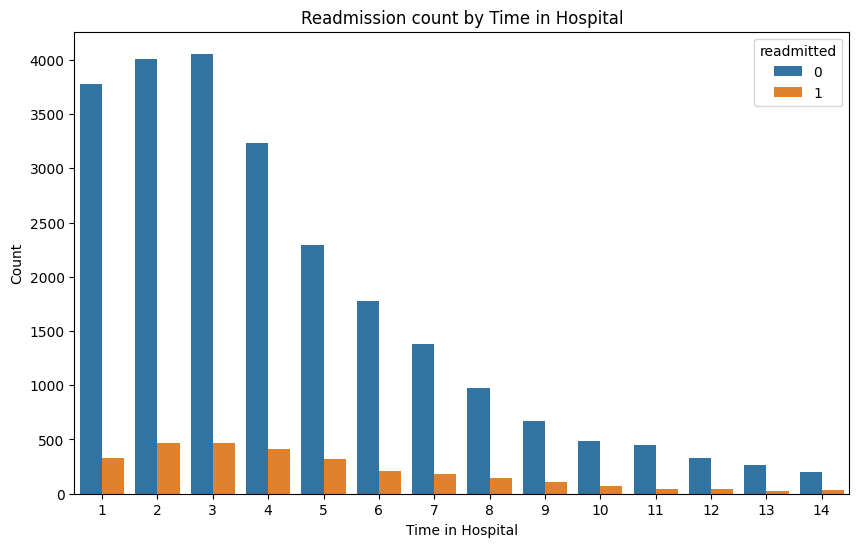

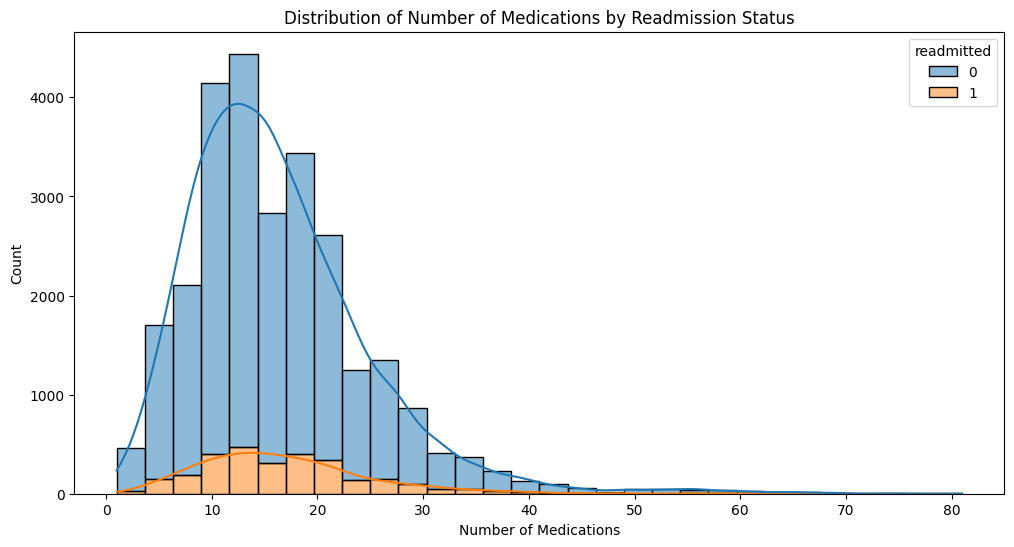

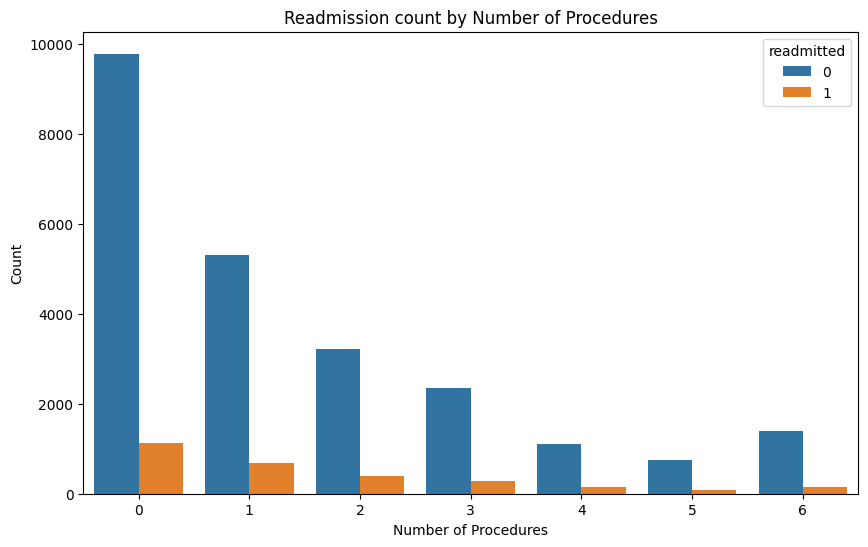

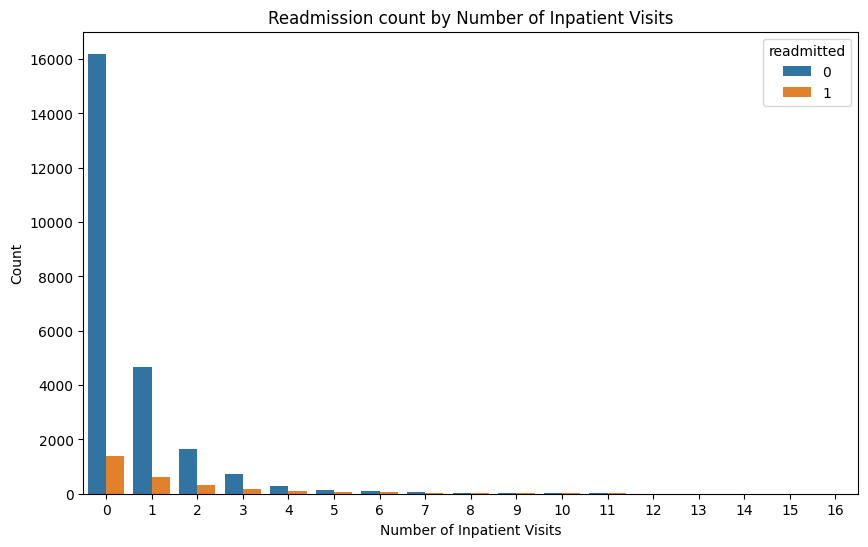

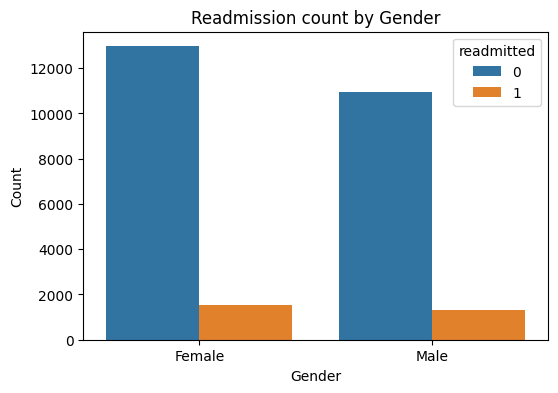

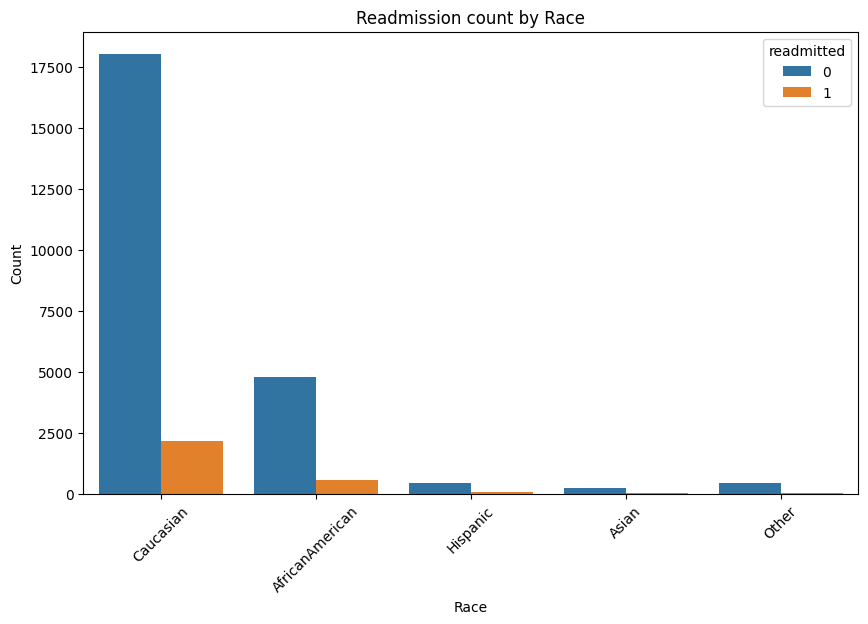

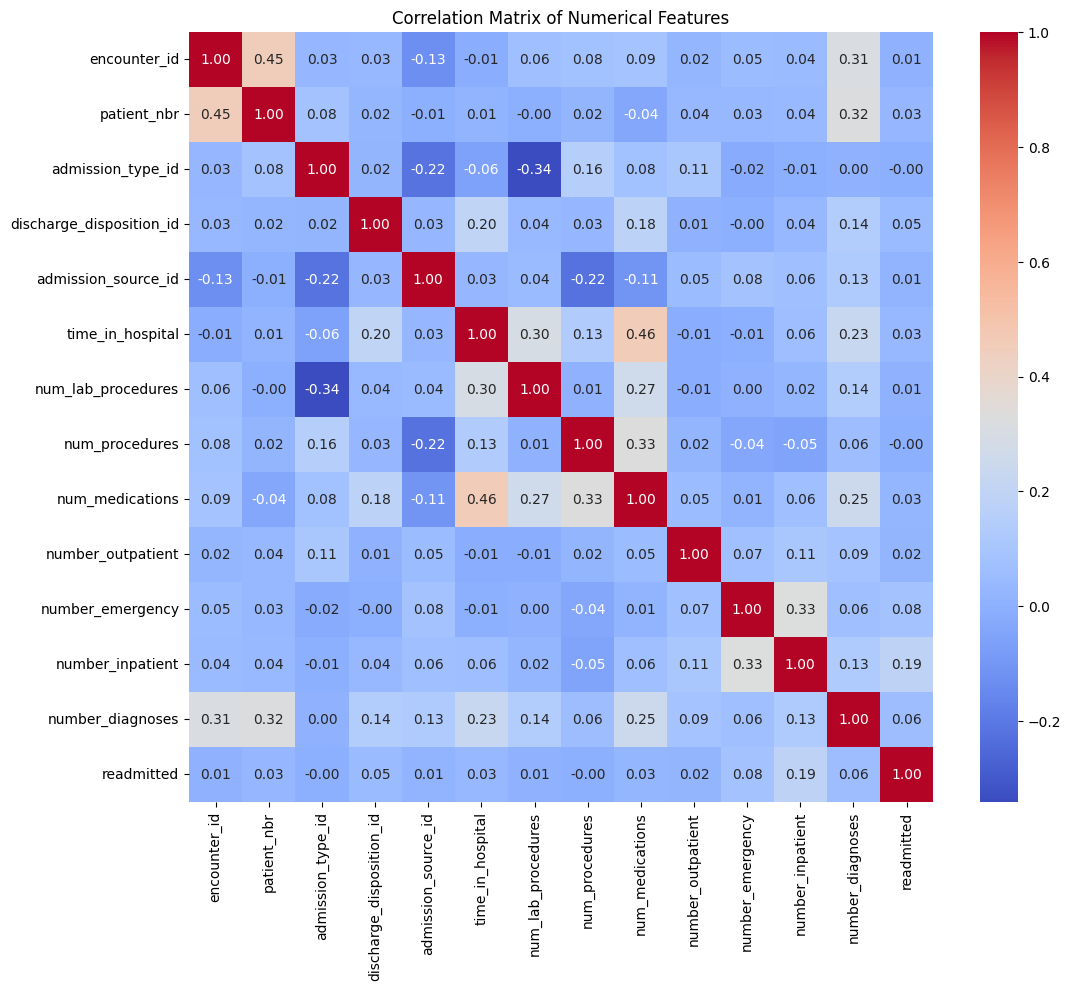

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze the relationship between age and readmission
plt.figure(figsize=(10, 6))
sns.countplot(x='age', hue='readmitted', data=df)
plt.title('Readmission count by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

# Analyze the relationship between time in hospital and readmission
plt.figure(figsize=(10, 6))
sns.countplot(x='time_in_hospital', hue='readmitted', data=df)
plt.title('Readmission count by Time in Hospital')
plt.xlabel('Time in Hospital')
plt.ylabel('Count')
plt.show()

# Analyze the relationship between number of medications and readmission
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='num_medications', hue='readmitted', multiple='stack', kde=True, bins=30)
plt.title('Distribution of Number of Medications by Readmission Status')
plt.xlabel('Number of Medications')
plt.ylabel('Count')
plt.show()

# Analyze the relationship between number of procedures and readmission
plt.figure(figsize=(10, 6))
sns.countplot(x='num_procedures', hue='readmitted', data=df)
plt.title('Readmission count by Number of Procedures')
plt.xlabel('Number of Procedures')
plt.ylabel('Count')
plt.show()

# Analyze the relationship between number of inpatient visits and readmission
plt.figure(figsize=(10, 6))
sns.countplot(x='number_inpatient', hue='readmitted', data=df)
plt.title('Readmission count by Number of Inpatient Visits')
plt.xlabel('Number of Inpatient Visits')
plt.ylabel('Count')
plt.show()

# Analyze the distribution of readmission by gender
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', hue='readmitted', data=df)
plt.title('Readmission count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Analyze the distribution of readmission by race
plt.figure(figsize=(10, 6))
sns.countplot(x='race', hue='readmitted', data=df)
plt.title('Readmission count by Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Display the correlation matrix for numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Exploratory Data Analysis (EDA)


## Data Cleaning


In [ ]:
# Handle missing values represented by '?'
df = df.replace('?', pd.NA)

# Check for missing values
print("Missing values before handling:")
print(df.isnull().sum())

# For simplicity in this example, we will drop columns with a high percentage of missing values.
# In a real-world scenario, more sophisticated imputation techniques might be used.
# Let's define a threshold for dropping columns
threshold = 0.5 * len(df)
df = df.dropna(axis=1, thresh=threshold)

# Drop rows with any remaining missing values
df = df.dropna()

print("\nMissing values after handling:")
print(df.isnull().sum())

# Convert target variable 'readmitted' to binary
# '<30' -> 1 (readmitted within 30 days)
# '>30' or 'NO' -> 0 (not readmitted within 30 days)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Check the distribution of the target variable
print("\nDistribution of the target variable 'readmitted':")
display(df['readmitted'].value_counts())

Missing values before handling:
encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride     

,count
readmitted,
0,23898
1,2857
